# Stock Price Forecasting Model

In this notebook, we will build a forecasting model for NTT's stock price data. The steps will include exploratory data analysis (EDA), data preprocessing, model training, evaluation, and model improvement. The goal is to forecast stock prices and evaluate the model's accuracy.



## 1. Data Understanding and EDA

- Loading the dataset and checking its basic statistics.
- Visualizing the trends, seasonality, and detect outliers.

In [24]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the stock price data
df = pd.read_csv('/content/stock_price.csv')

# Display the first few rows of the dataset
df.head()

,Date,Close Price,Open Price,High Price,Low Price,Volume,Change %
0,01-08-2024,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,31-07-2024,160.4,158.2,160.7,158.1,173.91M,1.07%
2,30-07-2024,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,29-07-2024,159.7,158.7,160.2,158.4,126.28M,1.14%
4,26-07-2024,157.9,159.3,159.6,157.9,155.08M,-0.13%


## 2. Data Preprocessing and Feature Engineering

- Feature Scaling

In [6]:
df1 = df.reset_index()['Close Price']

In [25]:
df1

array([[0.45181385],
       [0.46683767],
       [0.46060828],
       ...,
       [0.52216929],
       [0.51117626],
       [0.54745328]])

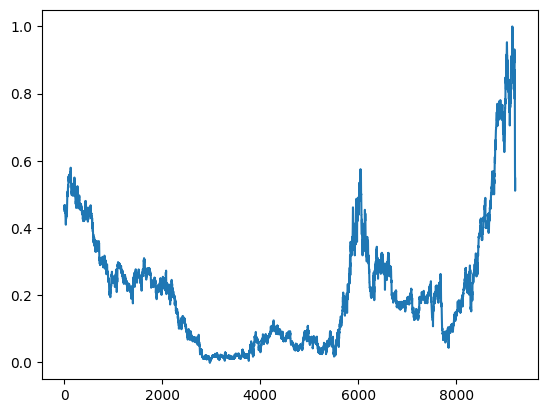

In [22]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to scale of the data so we apply MinMax scaler

In [9]:
import numpy as np


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [26]:
print(df1)

[[0.45181385]
 [0.46683767]
 [0.46060828]
 ...
 [0.52216929]
 [0.51117626]
 [0.54745328]]


In [11]:
## splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [27]:
training_size,test_size

(5981, 3221)

In [12]:
import numpy
# convert an array of values into datset matrix
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])

    return numpy.array(dataX),numpy.array(dataY)

In [13]:
#reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [15]:
#reshape into X=t,t+1,t+2,t+3 and t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [28]:
print(X_test.shape),print(y_test.shape)

(3120, 100, 1)
(3120,)


(None, None)

In [16]:
#reshape input to be [samples,time steps,features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## 3. Model Selection and Training


- Training the LSTM model using the preprocessed data.

In [29]:
#Create the stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - loss: 0.0073 - val_loss: 9.0324e-04
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - loss: 1.5409e-04 - val_loss: 8.9538e-04
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - loss: 1.5357e-04 - val_loss: 0.0011
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - loss: 1.5929e-04 - val_loss: 7.9459e-04
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - loss: 1.4215e-04 - val_loss: 6.6773e-04
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 1.3230e-04 - val_loss: 6.2368e-04
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - loss: 1.3738e-04 - val_loss: 5.1504e-04
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - loss: 1.2621e-04 - val_loss: 5.6125e-04
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - loss: 1.1171e-04 - val_loss: 4.6031e-04
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - loss: 1.1353e-04 - val_loss: 3.9662e-04
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202

In [40]:
model.save('Stock Predictions Model.keras')

## 4. Model Evaluation and Result Analysis

###Evaluating the model's performance using metrics and visualizing the results.
- Using RMSE metric.
- Plotting predicted vs actual values.

In [42]:
from keras.models import load_model

# Load the model
model = load_model('/content/Stock Predictions Model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

84.77961041419468

In [47]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

128.79471330683754

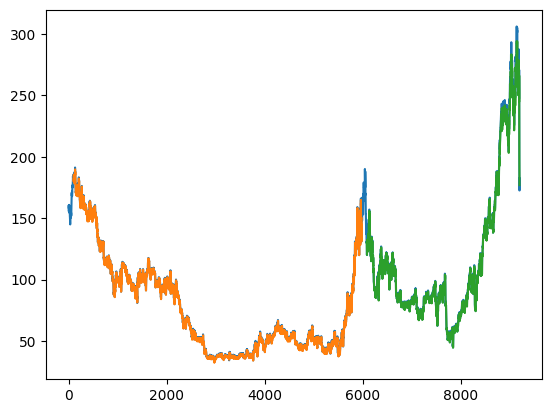

In [39]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
len(test_data)

3221

In [49]:
x_input=test_data[3121:].reshape(1,-1)
x_input.shape




(1, 100)

In [50]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [51]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.5585753]
101
1 day input [0.77720777 0.80945401 0.79149872 0.76987908 0.78783437 0.80249176
 0.80578967 0.82044705 0.82740931 0.78783437 0.82374496 0.86698424
 0.89593258 0.90289483 0.90655918 0.91022353 0.91022353 0.90289483
 0.90289483 0.89593258 0.89593258 0.90655918 0.89593258 0.89923049
 0.90289483 0.90289483 0.89923049 0.91022353 0.90289483 0.90289483
 0.91388787 0.90289483 0.89593258 0.91388787 0.91388787 0.93514108
 0.94246977 0.94979846 0.96775376 1.         0.99633565 0.99267131
 0.97471601 0.97471601 0.93184317 0.92085013 0.93880542 0.97471601
 0.98900696 0.98204471 0.99633565 0.95676072 0.92085013 0.88127519
 0.85269329 0.87431294 0.84170026 0.8453646  0.86698424 0.88127519
 0.88493954 0.87431294 0.89593258 0.87431294 0.88860388 0.85269329
 0.83107365 0.88493954 0.84170026 0.81311836 0.82044705 0.834738
 0.83107365 0.8453646  0.88493954 0.89593258 0.90655918 0.92085013
 0.92085013 0.90655918 0.89226823 0.90655918 0.91388787 0.93184317
 0.92085013 0.88493954 0.8453646  0.

In [52]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [53]:
import matplotlib.pyplot as plt

In [54]:
len(df1)

9202

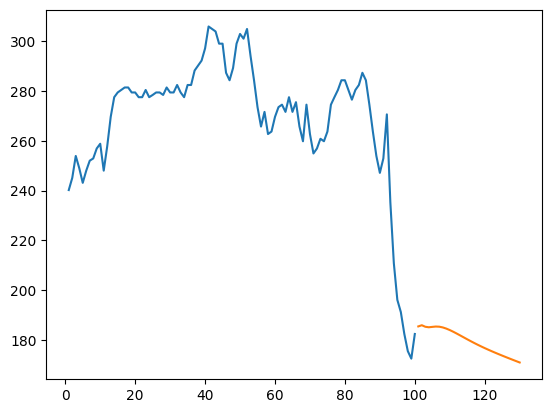

In [55]:
plt.plot(day_new,scaler.inverse_transform(df1[9102:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

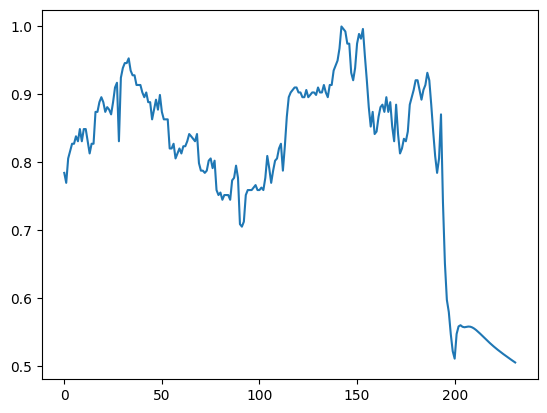

In [56]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[9000:])

In [57]:
df3=scaler.inverse_transform(df3).tolist()

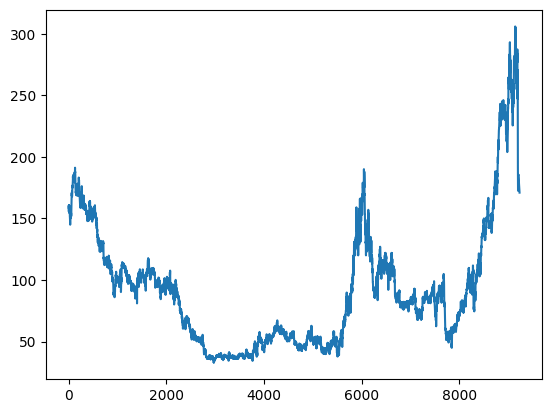

In [58]:
plt.plot(df3)